# EDA - Mobile-Driven Purchase Behavior Analysis 1

_An exploratory data analysis (EDA) focused on identifying user behavior patterns related to mobile purchasing, buyer confidence, demographics, impulsive buying influenced by discounts, and the synchronization between mobile usage habits and online shopping activity._

<div style="background-color:#cdcdcd;color:black;">

## 2. Hipótesis

</div>

- **Confianza del comprador** // Dataset 2<br>
Los usuarios que compran desde el móvil previamente han comprado desde Desktop

- **Confianza del comprador** // Dataset 2<br>
Hay relación entre plazos de entrega previos y la repetición de compra?

- **Perfil** // Dataset 2<br>
Hay diferencias de género o edad entre los compradores 'mobile' recurrentes?

- **Oferta** // Dataset 2<br>
Hay categorías de producto que destaquen para la primera compra móvil?

- **Compras impulsivas** // Dataset 2<br>
Tienen más efecto los descuentos en las compras móviles que en las Desktop?

- **Sincronía horaria de uso y compra** // Datasets 1 y 2 <br>
  ¿Se solapan las horas de mayor actividad en el móvil con las horas pico de compra online?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Cargo el CSV del Dataset 2 limpio.
df_2c = pd.read_csv('data\cleaned_ecommerce.csv')
df_2c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_date           51282 non-null  object 
 1   time                 51282 non-null  object 
 2   aging                51282 non-null  float64
 3   customer_id          51282 non-null  int64  
 4   gender               51282 non-null  object 
 5   device_type          51282 non-null  object 
 6   customer_login_type  51282 non-null  object 
 7   product_category     51282 non-null  object 
 8   product              51282 non-null  object 
 9   sales                51282 non-null  float64
 10  quantity             51282 non-null  float64
 11  discount             51282 non-null  float64
 12  profit               51282 non-null  float64
 13  shipping_cost        51282 non-null  float64
 14  order_priority       51282 non-null  object 
 15  payment_method       51282 non-null 

In [3]:
# Convierto a category algunas de las columnas object para que podamos trabajar mejor con ellas

# Columnas categóricas en df_2
cat_cols_df2 = ['gender', 'device_type', 'customer_login_type', 'product_category', 'order_priority', 'payment_method']

# Función para limpiar valores de texto/categoría   
def limpiar_categorias(df, columnas):
    for col in columnas:
        if df[col].dtype.name in ['object', 'category']:
            df[col] = df[col].str.strip().str.lower() # al aplicarle métodos de string se convierte en tipo object
            df[col] = df[col].astype('category') # volvemos a convertir a category (no es lo óptimo) :-/
    return df

# Aplicamos al dataframe
df_2c = limpiar_categorias(df_2c, cat_cols_df2)
df_2c.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   order_date           51282 non-null  object  
 1   time                 51282 non-null  object  
 2   aging                51282 non-null  float64 
 3   customer_id          51282 non-null  int64   
 4   gender               51282 non-null  category
 5   device_type          51282 non-null  category
 6   customer_login_type  51282 non-null  category
 7   product_category     51282 non-null  category
 8   product              51282 non-null  object  
 9   sales                51282 non-null  float64 
 10  quantity             51282 non-null  float64 
 11  discount             51282 non-null  float64 
 12  profit               51282 non-null  float64 
 13  shipping_cost        51282 non-null  float64 
 14  order_priority       51282 non-null  category
 15  payment_method     

<div style="background-color:#cdcdcd;color:black;">

## 5. Análisis específico de las Hipótesis
</div>

<div style="background-color:#909090;color:black;">

### Hipótesis 1. Confianza del comprador
#### Los usuarios que compran desde el móvil previamente han comprado desde Desktop
</div>

La premisa básica de esta hipótesis es que los usuarios, antes de optar por comprar a través del móvil, adquirirían confianza con el ecommerce gracias a compras previas realizadas desde la web, con algún dispositivo Desktop (ordenador).

Si esto fuera así, desde el departamento de marketing se plantearían realizar más acciones dirigidas a dar a conocer la aplicación móvil entre los compradores Desktop.

Para verificar esta hipótesis voy a dar los siguientes pasos:
1. Filtrar los usuarios que hayan comprado al menos una vez por móvil.
2. Para cada usuario, identificar la fecha de su primera compra móvil.
3. Comprobar si antes de esa fecha el usuario había comprado por Desktop.
4. Calcular el porcentaje de casos que cumplen la hipótesis

El resultado esperado es que los usuarios, en su mayoría, sí que llegan a la primera compra móvil después de haber hecho alguna compra Desktop.


#### 1.1. Filtrar los usuarios que hayan comprado al menos una vez por móvil.

In [72]:
# 1. Filtramos los usuarios que hayan comprado al menos una vez por móvil.

# 1.1 Primero creamos una columna nueva que unifica fecha y hora y sea de tipo datetime
df_2c['order_datetime'] = pd.to_datetime(df_2c['order_date'].astype(str) + ' ' + df_2c['time'].astype(str))

# 1.2 filtramos a un dataframe las compras hechas desde el móvil
mobile_sales_df = df_2c[df_2c['device_type'] == 'mobile']

# 1.3. guardamos los IDs únicos de quienes han comprado vía móvil
mobile_customers = mobile_sales_df['customer_id'].unique()

total_purchases = len(df_2c)
print('# compras:', total_purchases)
total_mobile_purchases = len(mobile_sales_df)
print('# compras desde móvil:', total_mobile_purchases)
total_mobile_users = len(mobile_customers)
print('# compradores únicos desde móvil:', total_mobile_users)

# compras: 51282
# compras desde móvil: 3658
# compradores únicos desde móvil: 3557


### 1.2. Para cada usuario, identificar la fecha de su primera compra móvil.

In [70]:
# 2. Para cada usuario, identificamos la fecha de su primera compra móvil.

# 2.1. Ordenamos por usuario y datetime
mobile_sales_df = mobile_sales_df.sort_values(['customer_id', 'order_datetime'])

# 2.2. Seleccionamos la primera compra móvil de cada usuario
first_mobile_purchase = mobile_sales_df.drop_duplicates(subset=['customer_id'], keep='first')


### 1.3. Comprobar si antes de esa fecha el usuario había comprado por Desktop.

In [87]:
# 3. Comprobamos si antes de esa fecha el usuario había comprado por Desktop.

# 3.1. Guardamos en un dataframe solo las compras desde la 'web' (Desktop)
desktop_sales_df = df_2c[df_2c['device_type'] == 'web']
total_desktop_purchases = len(desktop_sales_df)
print('# compras desde web:', total_desktop_purchases)

# 3.2. Hacemos merge para asociar la fecha de primera compra móvil a cada usuario
merged_df = pd.merge(
    first_mobile_purchase[['customer_id', 'order_datetime']],
    desktop_sales_df,
    on='customer_id',
    suffixes=('_mobile', '_desktop')
)
total_desktop_mobile_purchases = len(merged_df)
print('# compras web de usuarios que también han comprado vía móvil:', total_desktop_mobile_purchases)

# 3.3. Buscamos compras Desktop previas a la primera compra móvil de cada usuario
merged_df = merged_df[merged_df['order_datetime_desktop'] < merged_df['order_datetime_mobile']]
total_desktop_purchases_prior_mobile = len(merged_df)
print('# compras web anteriores a la primera compra móvil:', total_desktop_purchases_prior_mobile)

# compras desde web: 47624
# compras web de usuarios que también han comprado vía móvil: 1979
# compras web anteriores a la primera compra móvil: 989


### 1.4. Calcular el porcentaje de casos que cumplen la hipótesis

In [75]:
################### RESULTADO DE LA HIPÓTESIS ###################

# 4.1. Guardamos aquellos usuarios que han comprado en Desktop antes que en móvil
users_with_prior_desktop = merged_df['customer_id'].unique()
total_users_with_prior_desktop = len(users_with_prior_desktop)

# 4.2. Cálculo del % que cumplen la hipótesis
percent_with_prior_desktop = (total_users_with_prior_desktop / total_mobile_users) * 100

print('\n\t- Número de compradores únicos desde móvil:', total_mobile_users)
print('\t- Número de personas que compraron vía desktop antes que vía móvil:', total_users_with_prior_desktop)
print(f'\t- Porcentaje de personas que compran desde desktop antes de comprar desde móvil: {percent_with_prior_desktop:.2f} %')


	- Número de compradores únicos desde móvil: 3557
	- Número de personas que compraron vía desktop antes que vía móvil: 821
	- Porcentaje de personas que compran desde desktop antes de comprar desde móvil: 23.08 %


### 1.5. Conclusiones

La hipótesis planteaba que la mayoría de usuarios que compran desde el móvil lo hacen tras haber comprado previamente desde Desktop. Sin embargo, **los datos muestran que solo el 23% de los compradores móviles habían realizado antes alguna compra desde Desktop**.

Por tanto, la mayor parte de las compras móviles corresponden a usuarios que no habían comprado previamente desde Desktop, lo que indica que **el canal móvil es una puerta de entrada directa para muchos clientes**.

Esto subraya la importancia de optimizar la experiencia de compra móvil y diseñar estrategias de captación específicas para usuarios que comienzan su recorrido digital directamente desde este canal.

* NOTA METODOLÓGICA<br>
Es importante tener en cuenta que este análisis se basa únicamente en el identificador de usuario (customer_id). Existe la posibilidad de que una misma persona utilice diferentes cuentas o cree un nuevo usuario para futuras compras, por lo que no podemos garantizar que todos los casos de transición de Desktop a móvil queden reflejados en los datos. En consecuencia, el porcentaje de usuarios que realmente han realizado compras previas desde Desktop antes de comprar en móvil podría ser mayor de lo que muestran estos resultados.

### 1.6. Visualizaciones

#### 1.6.1. Diagrama de tarta con porcentajes

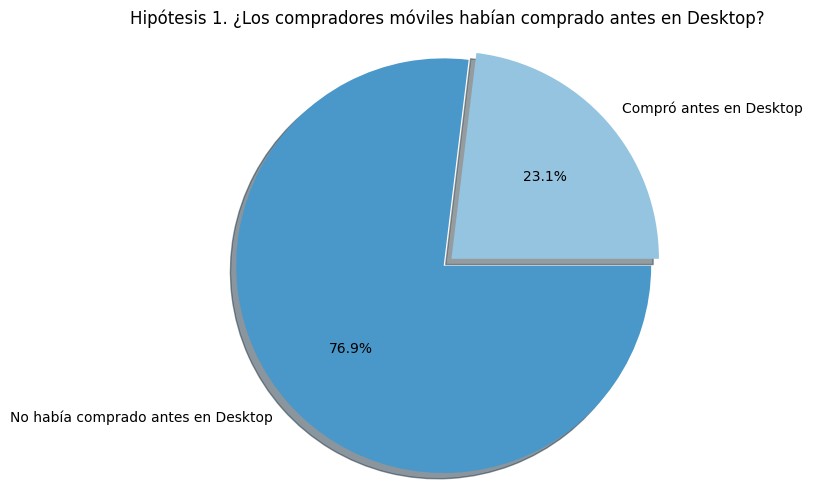

In [ ]:
# Datos
labels = ['Compró antes en Desktop', 'No había comprado antes en Desktop']
sizes = [total_users_with_prior_desktop, total_mobile_users - total_users_with_prior_desktop]  # 821 sí, 2736 no

# Estilo
colors = plt.cm.Blues([0.5, 0.8])
explode = (0.05, 0)  # Para resaltar la primera porción

plt.figure(figsize=(6, 6))
plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    explode=explode, 
    autopct='%1.1f%%',
    shadow=True
)
plt.title('Hipótesis 1. ¿Los compradores móviles habían comprado antes en Desktop?')
plt.axis('equal')  # Círculo perfecto

plt.show()


#### 1.6.2. Diagrama de barras secuenciales

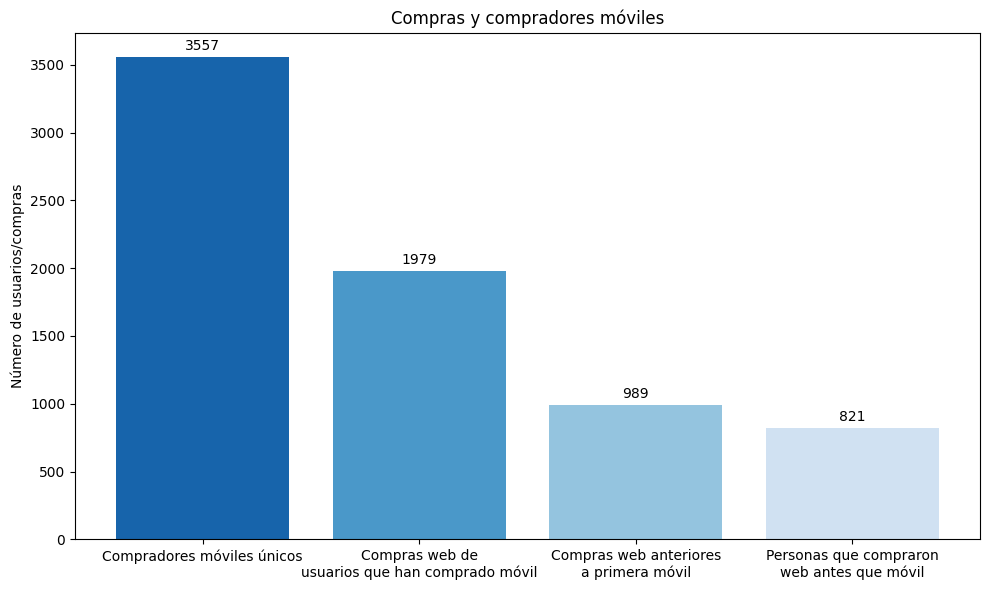

In [97]:
# Datos
etapas = [
    'Compradores móviles únicos',
    'Compras web de\nusuarios que han comprado móvil',
    'Compras web anteriores\na primera móvil',
    'Personas que compraron\nweb antes que móvil'
]
valores = [total_mobile_users, total_desktop_mobile_purchases, total_desktop_purchases_prior_mobile, total_users_with_prior_desktop]

plt.figure(figsize=(10, 6))
bars = plt.bar(
    etapas, 
    valores, 
    color=plt.cm.Blues([0.8, 0.6, 0.4, 0.2]))

plt.ylabel('Número de usuarios/compras')
plt.title('Compras y compradores móviles')

# Añade los valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 30,
        int(yval),
        ha='center',
        va='bottom'
        )

plt.tight_layout()
plt.show()
